In [32]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import numpy as np
from numpy.linalg import inv
import statsmodels.api as sm
import pandas as pd
import re
from sklearn.linear_model import LinearRegression

In [33]:
df = pd.read_csv('/Users/tiziana/Desktop/PYTHON/TESI MAGISTRALE/PCA/DATESET.csv')
df=df.iloc[:, 1:]
df.head()


df.set_index(['Country'],inplace=True)
gre = pd.DataFrame(df.loc['Portugal'])



gre.reset_index(inplace=True)
gre=gre.drop(['Country','Trimestre'],axis=1)

In [34]:
dftest = adfuller(gre['Gdp growth'], autolag="AIC")
dfoutput = pd.Series(
dftest[0:4],
index=[
"Test Statistic",
"p-value",
"#Lags Used",
"Number of Observations Used",
],
)
if dftest[1] < 0.05:
    print(f'Gdp growth is Stationary ')
else:
    print('Non stationary')



dftest = adfuller(gre['Current Account'], autolag="AIC")
dfoutput = pd.Series(
dftest[0:4],
index=[
"Test Statistic",
"p-value",
"#Lags Used",
"Number of Observations Used",
],
)
if dftest[1] < 0.05:
    print('Current Account is Stationary')
else:
    print('Current Account Non stationary')


dftest = adfuller(gre['Public Debt'], autolag="AIC")
dfoutput = pd.Series(
dftest[0:4],
index=[
"Test Statistic",
"p-value",
"#Lags Used",
"Number of Observations Used",
],
)
if dftest[1] < 0.05:
    print('Public Debt is Stationary')
else:
    print('Public Debt Non stationary')



dftest = adfuller(gre['Financial index'], autolag="AIC")
dfoutput = pd.Series(
dftest[0:4],
index=[
"Test Statistic",
"p-value",
"#Lags Used",
"Number of Observations Used",
],
)
if dftest[1] < 0.05:
    print(f'Financial Index is Stationary con p-value{dftest[1]}')
else:
    print(f'Financial Index Non stationary con p-value {dftest[1]}')

Gdp growth is Stationary 
Current Account Non stationary
Public Debt Non stationary
Financial Index Non stationary con p-value 0.08542293689044506


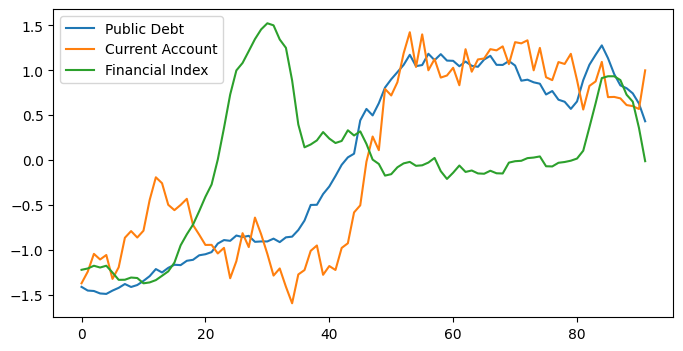

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(8, 4))
plt.plot(gre['Public Debt'], label='Public Debt')
plt.plot(gre['Current Account'], label='Current Account')
plt.plot(gre['Financial index'], label='Financial Index')


plt.legend()

In [36]:
gre['Gdp growth']=gre['Gdp growth']
gre['Current Account'] = gre['Current Account'].diff(1)
gre['Public Debt'] = gre['Public Debt'].diff(1)
gre['Financial index'] = gre['Financial index'].diff(1)

gre=gre.iloc[1:]


In [37]:
dftest = adfuller(gre['Current Account'], autolag="AIC")
dfoutput = pd.Series(
dftest[0:4],
index=[
"Test Statistic",
"p-value",
"#Lags Used",
"Number of Observations Used",
],
)
if dftest[1] < 0.05:
    print('Current Account is Stationary')
else:
    print('Current Account Non stationary')


dftest = adfuller(gre['Public Debt'], autolag="AIC")
dfoutput = pd.Series(
dftest[0:4],
index=[
"Test Statistic",
"p-value",
"#Lags Used",
"Number of Observations Used",
],
)
if dftest[1] < 0.05:
    print('Public Debt is Stationary')
else:
    print('Public Debt Non stationary')



dftest = adfuller(gre['Financial index'], autolag="AIC")
dfoutput = pd.Series(
dftest[0:4],
index=[
"Test Statistic",
"p-value",
"#Lags Used",
"Number of Observations Used",
],
)
if dftest[1] < 0.05:
    print('Financial Index is Stationary')
else:
    print('Financial Index Non stationary')

Current Account is Stationary
Public Debt is Stationary
Financial Index is Stationary


In [38]:
from statsmodels.tsa.api import VAR
model = VAR(gre)
lag_order = model.select_order(maxlags=8)  
lag_order.summary()

,AIC,BIC,FPE,HQIC
0,-11.49,-11.37,1.025e-05,-11.44
1,-12.47*,-11.89*,3.847e-06*,-12.23*
2,-12.32,-11.27,4.472e-06,-11.90
3,-12.25,-10.74,4.829e-06,-11.64
4,-12.04,-10.06,6.035e-06,-11.25
5,-11.90,-9.456,7.076e-06,-10.92
6,-11.82,-8.903,7.967e-06,-10.65
7,-11.73,-8.346,9.130e-06,-10.37
8,-11.85,-8.008,8.555e-06,-10.31


In [39]:
gre= gre.reindex(columns=['Financial index','Gdp growth','Current Account','Public Debt'])

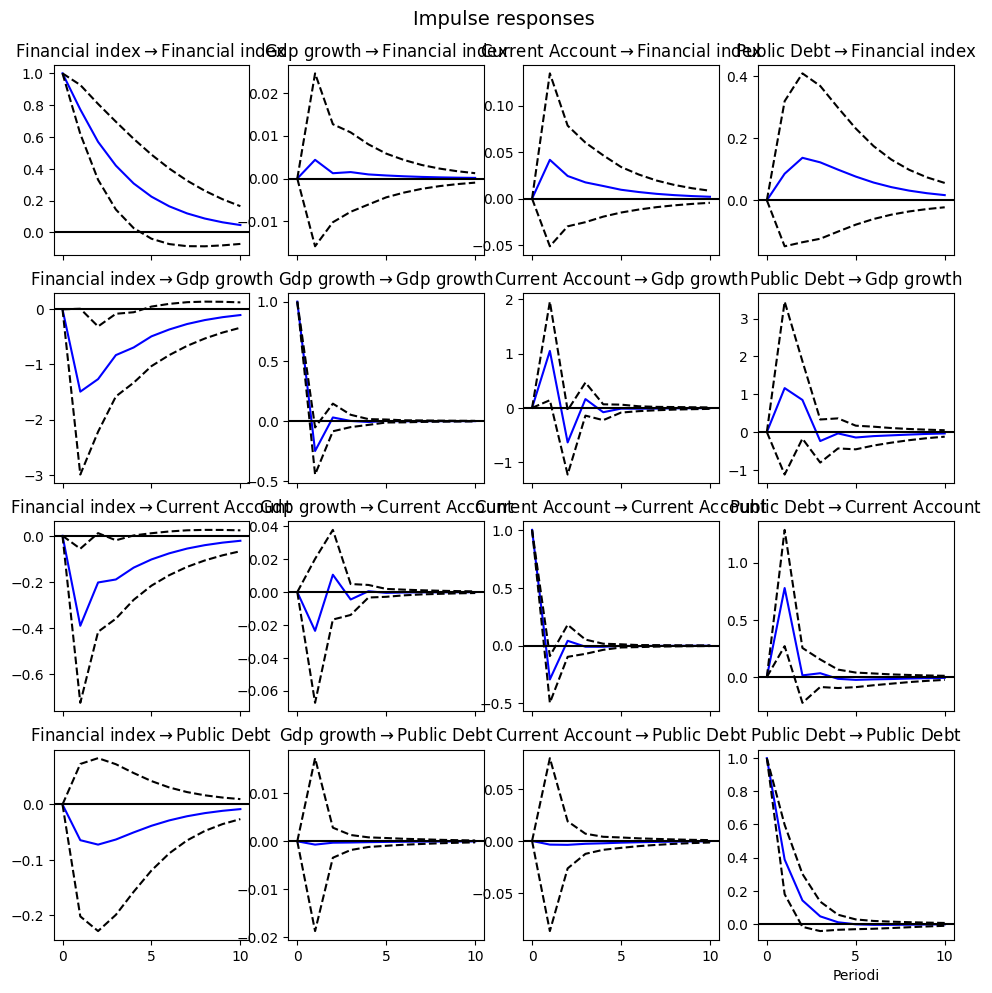

<statsmodels.tsa.vector_ar.hypothesis_test_results.WhitenessTestResults object. H_0: residual autocorrelation up to lag 10 is zero: fail to reject at 5% significance level. Test statistic: 164.471, critical value: 173.004>, p-value: 0.117>


In [40]:
model = sm.tsa.VAR(gre)

# Stima il modello con un ordine di 6
results = model.fit(1)
irf = results.irf(10)

irf.plot(orth=False)
plt.xlabel('Periodi')

plt.show()
whiteness_test_result = results.test_whiteness(nlags=10)
print(whiteness_test_result)

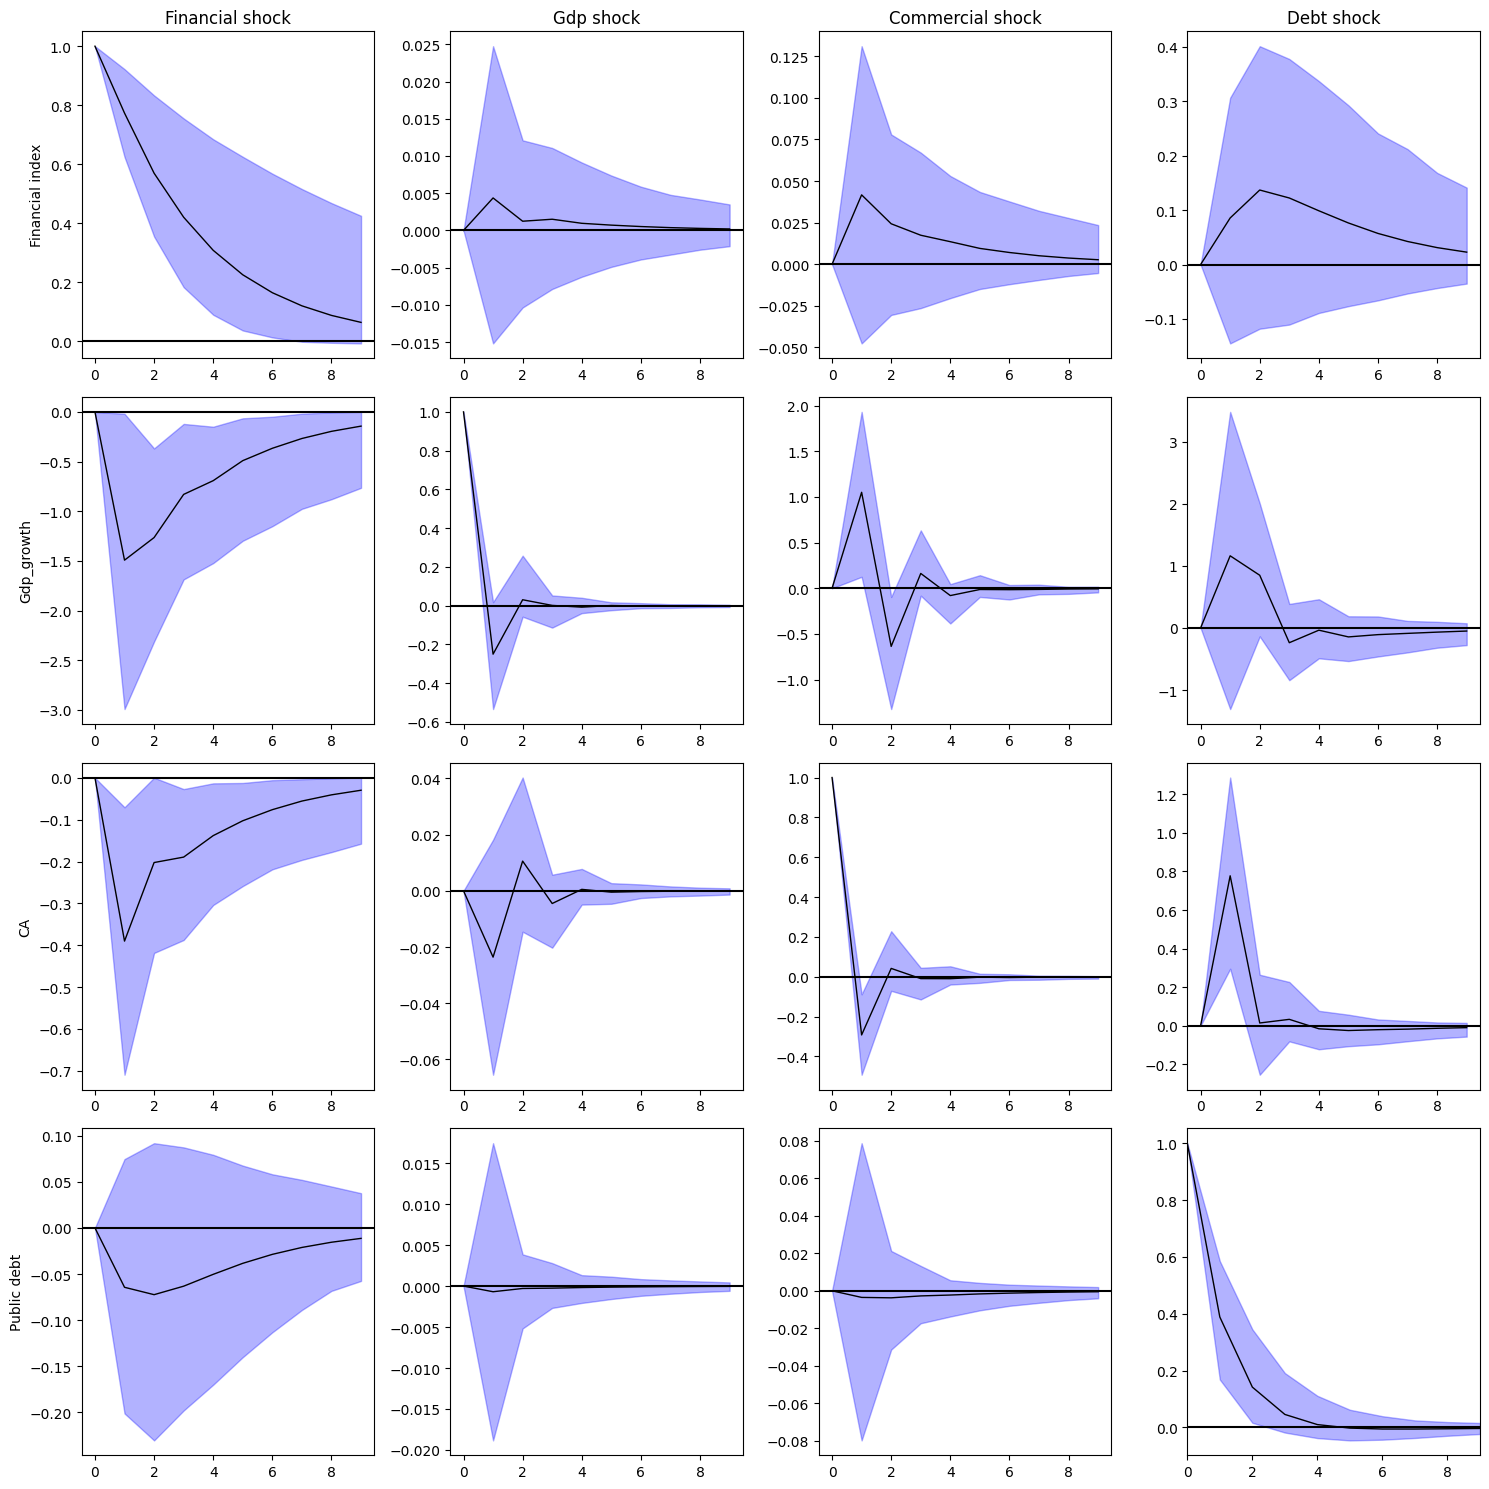

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re


m = 4  # Considered Variable
p = 1  # Number of lags based on AIC criterion
c = 1  # Constant term
h = 10 # IRF horizon

T = len(gre)
Y = gre.iloc[p:, :]  # Adjust for lags

# Create lagged matrix
X_lagged = pd.DataFrame()
for col in gre.columns:
    for i in range(1, p+1):
        X_lagged[f'{col}_lag_{i}'] = gre[col].shift(i)
X_lagged = X_lagged.iloc[p:, :]
X_lagged = X_lagged[[col for lag in sorted(set(int(re.search(r'_lag_(\d+)$', col).group(1)) if re.search(r'_lag_(\d+)$', col) else 0 for col in X_lagged.columns)) for col in [x for x in X_lagged.columns if re.search(fr'_lag_{lag}$', x)]] + [x for x in X_lagged.columns if not re.search(r'_lag_\d+$', x)]]
X_lagged.insert(0, 'const', 1)

# Estimate VAR model
pi_hat = np.dot(np.dot(np.linalg.inv(np.dot(X_lagged.T, X_lagged)), X_lagged.T), Y)
Y_fit = np.dot(X_lagged, pi_hat)
err = Y - Y_fit

A_comp = np.block([
    [pi_hat[1:, :].T],
    [np.eye(m * p - m), np.zeros((m * p - m, m))]
])

PHI = np.zeros((m, m, h))
for j in range(h):
    PHI_comp = np.linalg.matrix_power(A_comp, j)
    PHI[:, :, j] = PHI_comp[:m, :m]

PHI_plot = np.reshape(np.transpose(PHI, (2, 0, 1)), (h, m*m))

VARnames = ['Financial index', 'Gdp_growth', 'CA', 'Public debt']
Shocknames = ['Financial shock', 'Gdp shock', 'Commercial shock', 'Debt shock']

ylab = 0

# Bootstrap simulation to compute confidence intervals
n_bootstrap = 1000
alpha = 0.05
bootstrap_phis = np.zeros((n_bootstrap, m, m, h))

for b in range(n_bootstrap):
    # Resample residuals
    resampled_err = err.sample(frac=1, replace=True).values
    Y_bootstrap = Y_fit + resampled_err

    # Re-estimate the VAR model
    pi_hat_bootstrap = np.dot(np.dot(np.linalg.inv(np.dot(X_lagged.T, X_lagged)), X_lagged.T), Y_bootstrap)
    A_comp_bootstrap = np.block([
        [pi_hat_bootstrap[1:, :].T],
        [np.eye(m * p - m), np.zeros((m * p - m, m))]
    ])

    for j in range(h):
        PHI_comp_bootstrap = np.linalg.matrix_power(A_comp_bootstrap, j)
        bootstrap_phis[b, :, :, j] = PHI_comp_bootstrap[:m, :m]

lower_bound = np.percentile(bootstrap_phis, alpha/2*100, axis=0)
upper_bound = np.percentile(bootstrap_phis, (1-alpha/2)*100, axis=0)

fig, axes = plt.subplots(m, m, figsize=(15, 15))
axes_flat = axes.flatten()
for k in range(m*m):
    ax = axes_flat[k]
    ax.plot(np.arange(h), PHI_plot[:, k], linewidth=1, color='k')
    lb = lower_bound[k // m, k % m, :]
    ub = upper_bound[k // m, k % m, :]
    ax.fill_between(np.arange(h), lb, ub, color='blue', alpha=0.3)
    ax.axhline(0, color='k', linestyle='-')
    if k < 4:
        ax.set_title(Shocknames[k])
    if k in [0, 4, 8, 12]:  # Corrected indices for labels
        ax.set_ylabel(VARnames[ylab])
        ylab += 1
ax.set_xlim([0, h-1])
plt.tight_layout()
plt.show()


In [42]:
coefficents = pd.DataFrame(pi_hat)
coefficents.columns = ['Financial index','Gdp growth','Current Account','Public Debt']
coefficents.index = ['Const.','Fi_l1','Gdp_l1','Ca_l1','Pd_l1']
coefficents=coefficents.transpose()
coefficents

,Const.,Fi_l1,Gdp_l1,Ca_l1,Pd_l1
Financial index,-0.003127,0.773156,0.004366,0.041707,0.085646
Gdp growth,-0.027084,-1.492473,-0.250262,1.050283,1.162915
Current Account,0.020380,-0.390045,-0.023603,-0.292318,0.777527
Public Debt,0.013348,-0.064378,-0.000691,-0.003527,0.388379


In [43]:
sigma_hat = np.dot(err.T, err) / (T - p - 1)
X_lagged_inv = np.linalg.inv(np.dot(X_lagged.T, X_lagged))
var_cov_matrix = np.kron(sigma_hat, X_lagged_inv)
std_err = np.sqrt(np.diag(var_cov_matrix).reshape(pi_hat.shape))

# Create DataFrame for standard errors
std_err_df = pd.DataFrame(std_err, index=coefficents.columns, columns=[col + '_std' for col in coefficents.index])
std_err_df=std_err_df.transpose()

t_values = pi_hat / std_err
t_values_df = pd.DataFrame(t_values, index=coefficents.columns, columns=[col + '_t' for col in coefficents.index])


In [44]:
from scipy.stats import t
degrees_of_freedom = T - (m * p) - 1
p_values = 2 * (1 - t.cdf(np.abs(t_values), df=degrees_of_freedom))

# Create DataFrame for p-values
p_values_df = pd.DataFrame(p_values, index=coefficents.columns, columns=[col + '_p' for col in coefficents.index])
print("p-values DataFrame:")
p_values_df.transpose()


p-values DataFrame:


,Const.,Fi_l1,Gdp_l1,Ca_l1,Pd_l1
Financial index_p,0.763836,2.868826e-09,0.992333,0.059586,0.214989
Gdp growth_p,0.724799,0.000000e+00,0.826827,0.000000,0.000000
Current Account_p,0.045887,6.040928e-01,0.297679,0.251849,0.000000
Public Debt_p,0.774104,5.143863e-01,0.996696,0.704677,0.000351


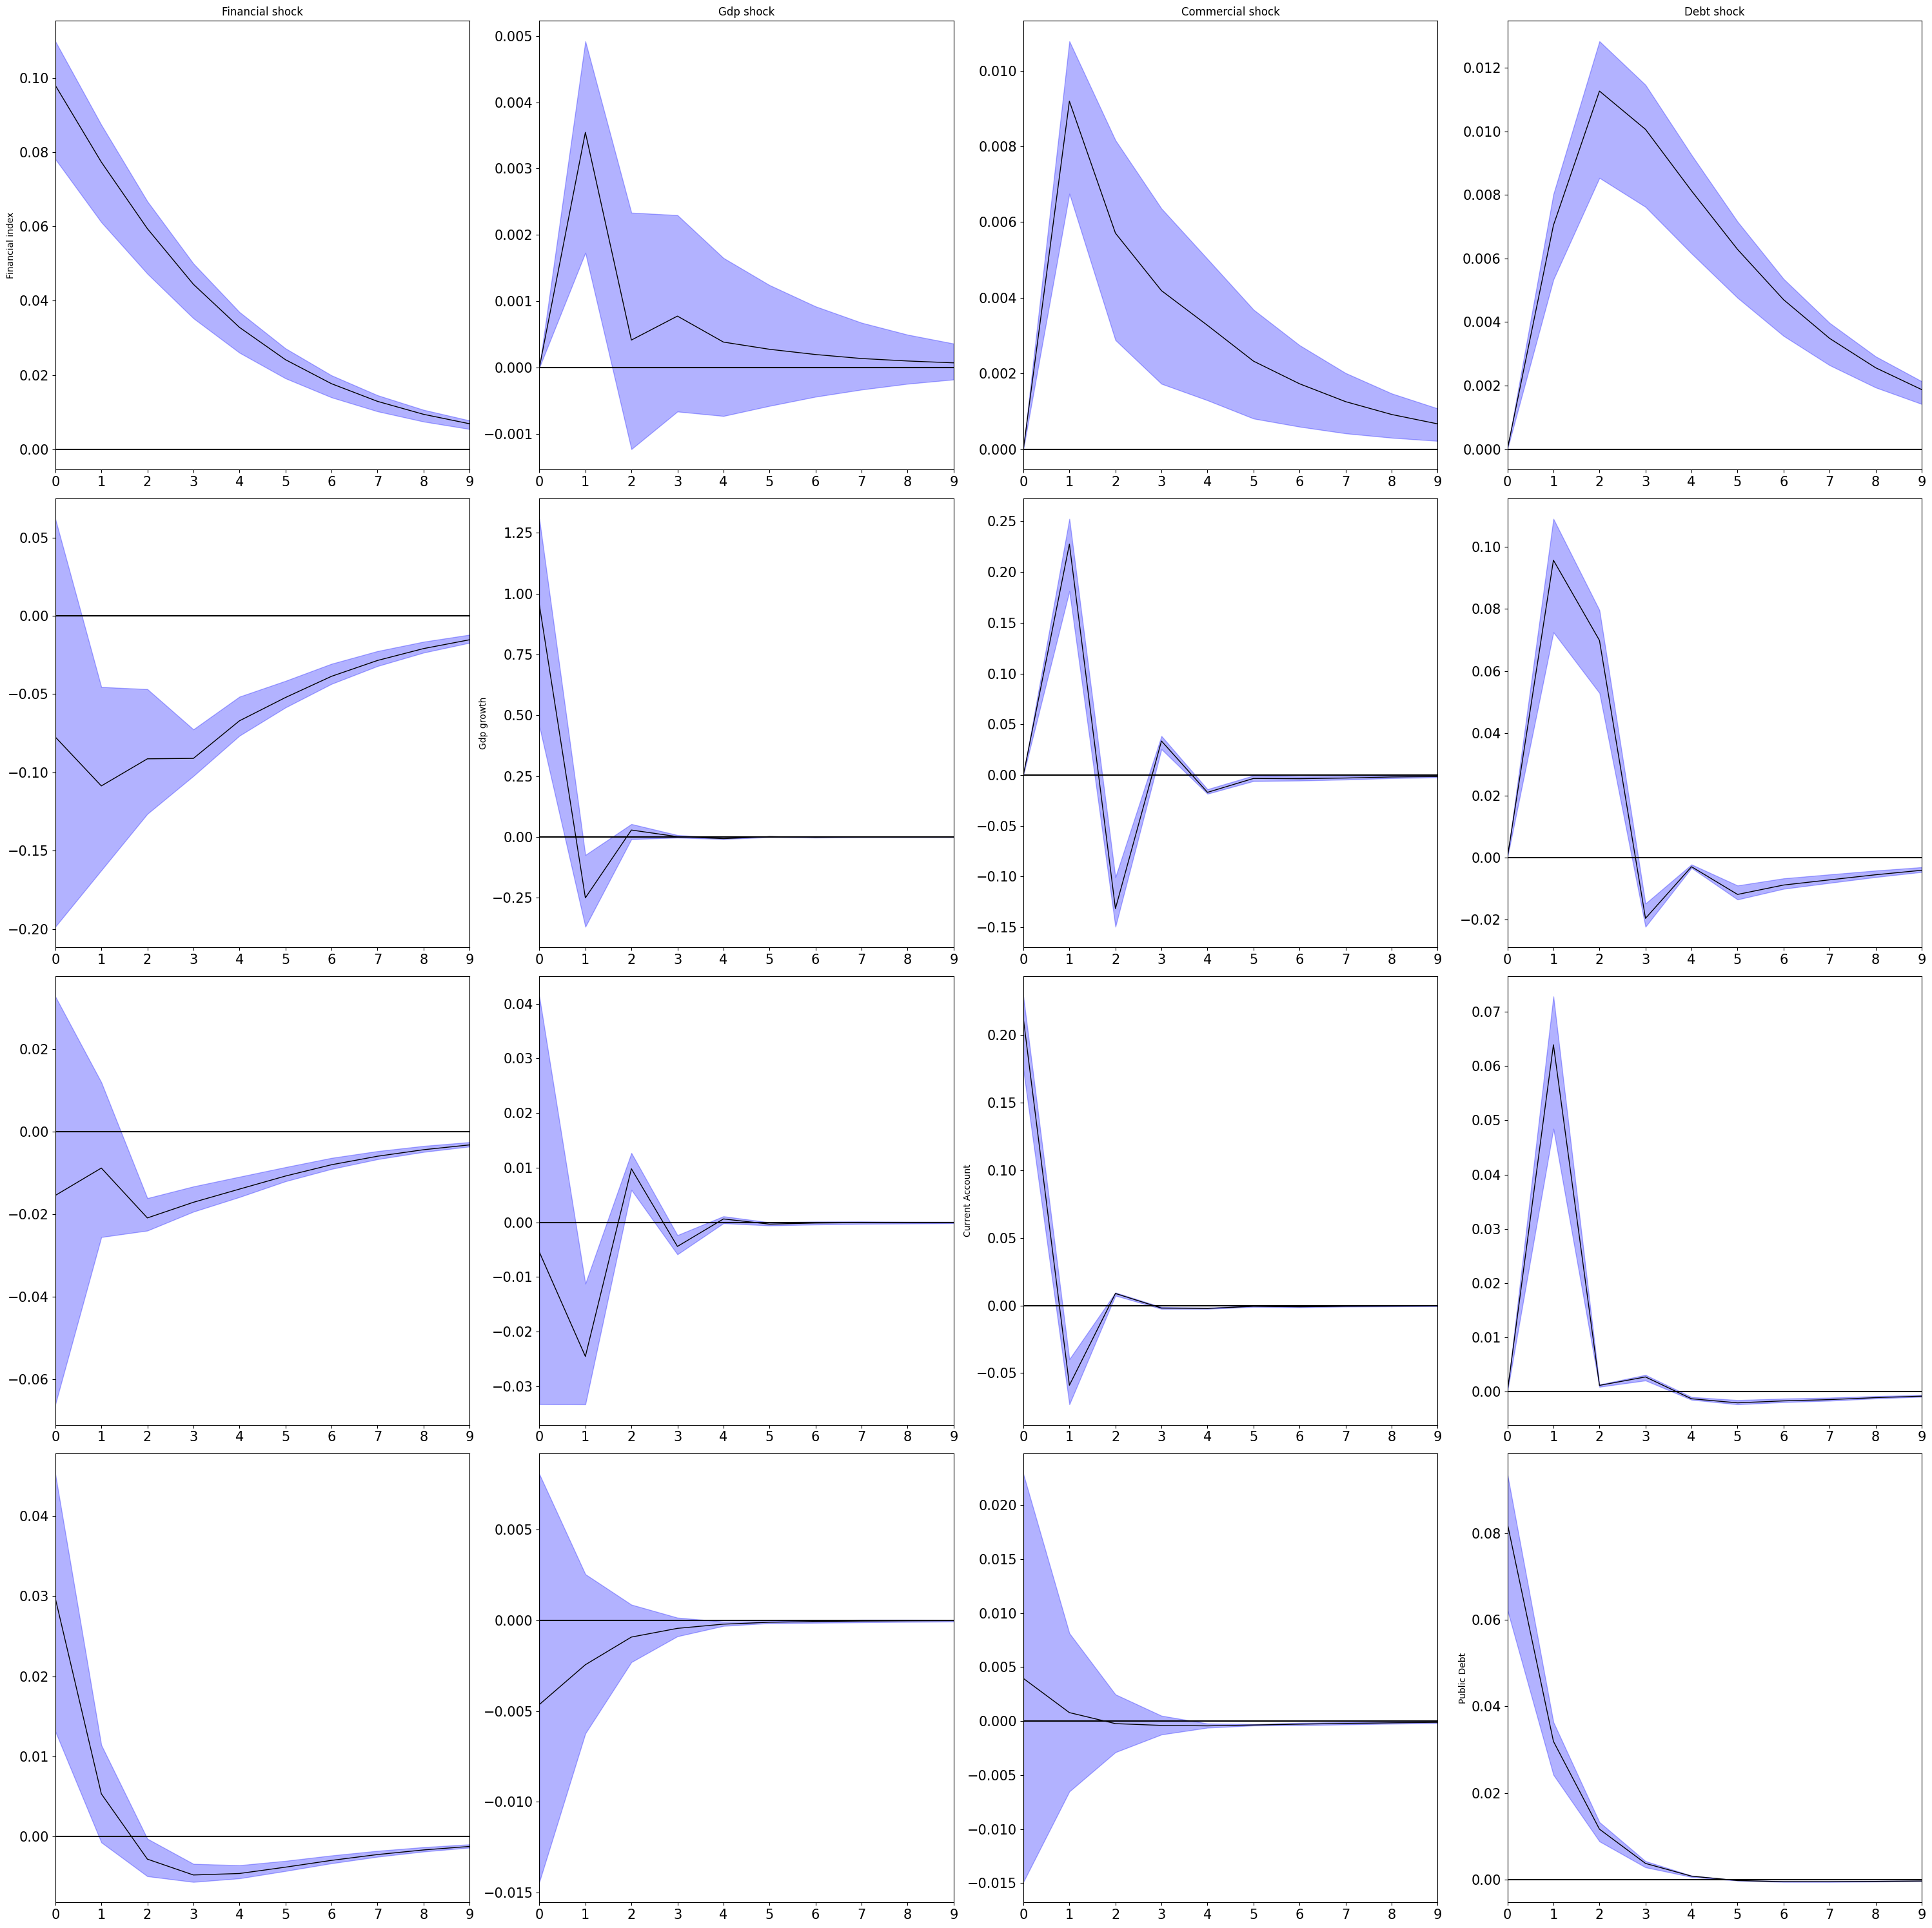

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Dati e parametri del modello VAR
T = len(gre) - m * p - m  # Lunghezza dei dati
omega = np.dot(err.T, err) / T  # Matrice di covarianza dei residui
P = np.linalg.cholesky(omega)  # Decomposizione di Cholesky di omega
PHI_SR = np.zeros((m, m, h))  # Matrice delle IRF

# Calcolo delle IRF
for i in range(h):
    PHI_SR[:, :, i] = np.dot(PHI[:, :, i], P)

# Plot delle IRF
PHI_SR_plot = np.reshape(np.transpose(PHI_SR, (2, 0, 1)), (h, m * m))

# Nomi delle variabili e degli shock
VARnames = ['Financial index', 'Gdp growth', 'Current Account', 'Public Debt']
Shocknames = ['Financial shock', 'Gdp shock', 'Commercial shock', 'Debt shock']

# Creazione della figura e dei subplot
fig, axes = plt.subplots(m, m, figsize=(30, 30))
axes_flat = axes.flatten()
ylab = 0

# Parametri del bootstrap
B = 1000  # Numero di bootstrap
percentile = 95  # Intervallo di confidenza del 95%

# Bootstrap per calcolare gli intervalli di confidenza
PHI_SR_bootstrap = np.zeros((B, h, m * m))

for b in range(B):
    # Resampling con ripetizione dei residui
    err_bootstrap = err.sample(n=T, replace=True, axis=0).to_numpy()
    
    # Calcolo della matrice di covarianza dei residui bootstrap
    omega_bootstrap = np.dot(err_bootstrap.T, err_bootstrap) / T
    
    # Decomposizione di Cholesky di omega_bootstrap
    P_bootstrap = np.linalg.cholesky(omega_bootstrap)
    
    # Calcolo delle IRF bootstrap
    PHI_SR_bootstrap_b = np.zeros((m, m, h))
    for i in range(h):
        PHI_SR_bootstrap_b[:, :, i] = np.dot(PHI[:, :, i], P_bootstrap)
    
    PHI_SR_bootstrap[b, :, :] = np.reshape(np.transpose(PHI_SR_bootstrap_b, (2, 0, 1)), (h, m * m))

# Calcolo degli intervalli di confidenza
lower_bound = np.percentile(PHI_SR_bootstrap, (100 - percentile) / 2, axis=0)
upper_bound = np.percentile(PHI_SR_bootstrap, 100 - (100 - percentile) / 2, axis=0)

# Grafico delle IRF con intervalli di confidenza
for k in range(m * m):
    ax = axes_flat[k]
    ax.plot(np.arange(h), PHI_SR_plot[:, k], linewidth=1, color='k', label='IRF')
    ax.fill_between(np.arange(h), lower_bound[:, k], upper_bound[:, k], color='blue', alpha=0.3, label='CI')
    ax.axhline(0, color='k', linestyle='-')
    
    if k < 4: 
        ax.set_title(Shocknames[k])
    if k in [0, 5, 10, 15]: 
        ax.set_ylabel(VARnames[ylab])
        ylab += 1

    ax.set_xlim([0, h - 1])
    ax.tick_params(axis='both', which='major', labelsize=15)

plt.tight_layout()
plt.show()


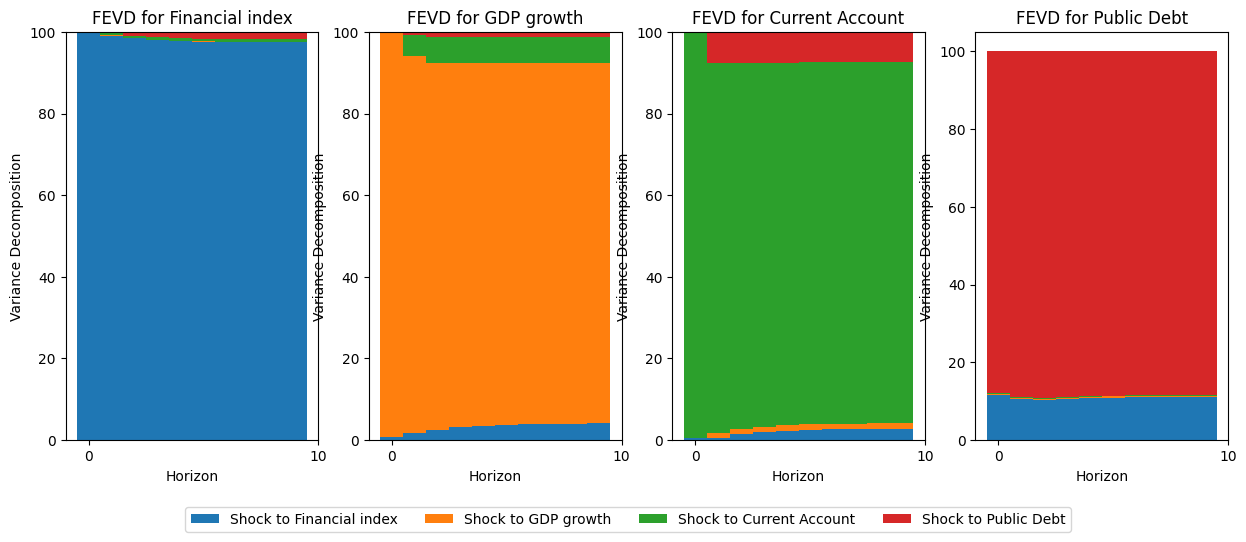

In [46]:
h = 10
MSE = np.zeros((m, m, h))
MSE_shock = np.zeros((m, m, h))
FEVD = np.zeros((h, m, m))

MSE[:, :, 0] = omega
for ii in range(m):
    for nn in range(1, h):
        MSE[:, :, nn] = MSE[:, :, nn - 1] + PHI[:, :, nn] @ omega @ PHI[:, :, nn].T
    MSE_shock[:, :, 0] = P[:, ii].reshape(-1, 1) @ P[:, ii].reshape(1, -1)

    for nn in range(1, h):
        MSE_shock[:, :, nn] = MSE_shock[:, :, nn - 1] + PHI[:, :, nn] @ MSE_shock[:, :, 0] @ PHI[:, :, nn].T
    FECD = MSE_shock[:, :, :] / MSE[:, :, :]

    for nn in range(h):
        for kk in range(m):
            FEVD[nn, ii, kk] = 100 * FECD[kk, kk, nn]

def plot_FEVD(FEVD_result, variable_names, horizon=40):
    """
    Plot FEVD results using stacked bar plots in subplots.
    FEVD_result: The FEVD matrix of shape (n, n, horizon)
    variable_names: List of names of the variables
    horizon: The number of periods ahead for the forecast
    """
    FEVD_result = FEVD_result.transpose((2, 1, 0))
    n = FEVD_result.shape[0]
    cols = 4
    rows = int(np.ceil(n / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(15, 6 * rows))
    fig.subplots_adjust(bottom=0.2, hspace=0.4)

    if rows == 1:
        axes = axes.flatten()
    for i in range(n):
        ax = axes[i // cols, i % cols] if rows > 1 else axes[i]
        bottom_values = np.zeros(horizon)
        for j in range(n):
            ax.bar(np.arange(horizon), FEVD_result[i, j, :], bottom=bottom_values, width=1, label=f"Shock to {variable_names[j]}")
            bottom_values += FEVD_result[i, j, :]
        ax.set_title(f"FEVD for {variable_names[i]}")
        ax.set_xlabel("Horizon")
        ax.set_ylabel("Variance Decomposition")
        ax.set_xticks(np.linspace(0, horizon, int(horizon / 10) + 1, endpoint=True))

    for i in range(n, rows * cols):
        ax = axes[i // cols, i % cols] if rows > 1 else axes[i]
        ax.axis('off')

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.1), ncol=len(variable_names))

variable_names = ['Financial index','GDP growth', 'Current Account', 'Public Debt']
plot_FEVD(FEVD, variable_names, h)


In [48]:
from statsmodels.tsa.stattools import grangercausalitytests
grangercausalitytests(gre[['Current Account', 'Financial index']], 3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5949  , p=0.1108  , df_denom=87, df_num=1
ssr based chi2 test:   chi2=2.6844  , p=0.1013  , df=1
likelihood ratio test: chi2=2.6452  , p=0.1039  , df=1
parameter F test:         F=2.5949  , p=0.1108  , df_denom=87, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.9020  , p=0.1556  , df_denom=84, df_num=2
ssr based chi2 test:   chi2=4.0304  , p=0.1333  , df=2
likelihood ratio test: chi2=3.9418  , p=0.1393  , df=2
parameter F test:         F=1.9020  , p=0.1556  , df_denom=84, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.3326  , p=0.2695  , df_denom=81, df_num=3
ssr based chi2 test:   chi2=4.3434  , p=0.2267  , df=3
likelihood ratio test: chi2=4.2396  , p=0.2367  , df=3
parameter F test:         F=1.3326  , p=0.2695  , df_denom=81, df_num=3


{1: ({'ssr_ftest': (2.5949306109471033, 0.11082851300669207, 87.0, 1),
   'ssr_chi2test': (2.6844109768418307, 0.10133469002410363, 1),
   'lrtest': (2.645155955059465, 0.10386596366676523, 1),
   'params_ftest': (2.5949306109470816, 0.1108285130066932, 87.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (1.9019907829884022, 0.1556442921444437, 84.0, 2),
   'ssr_chi2test': (4.03040904014209, 0.13329313945568466, 2),
   'lrtest': (3.9418143522260607, 0.1393304016532456, 2),
   'params_ftest': (1.901990782988391, 0.1556442921444447, 84.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (1.332645191887849, 0.2695362676044057, 81.0, 3),
   'ssr_chi2test': (4.343436180967804, 0.22668782321869638, 3),
   'lrtest': (4.239647647646393, 0.23672226014734282, 3),
   'params_ftest': (1.3326451918878452, 0.2695362676044078, 81.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0.,

In [49]:
grangercausalitytests(gre[['Public Debt', 'Financial index']], 3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8565  , p=0.3573  , df_denom=87, df_num=1
ssr based chi2 test:   chi2=0.8860  , p=0.3466  , df=1
likelihood ratio test: chi2=0.8817  , p=0.3477  , df=1
parameter F test:         F=0.8565  , p=0.3573  , df_denom=87, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.9525  , p=0.3899  , df_denom=84, df_num=2
ssr based chi2 test:   chi2=2.0184  , p=0.3645  , df=2
likelihood ratio test: chi2=1.9959  , p=0.3686  , df=2
parameter F test:         F=0.9525  , p=0.3899  , df_denom=84, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.8377  , p=0.4771  , df_denom=81, df_num=3
ssr based chi2 test:   chi2=2.7303  , p=0.4351  , df=3
likelihood ratio test: chi2=2.6888  , p=0.4421  , df=3
parameter F test:         F=0.8377  , p=0.4771  , df_denom=81, df_num=3


{1: ({'ssr_ftest': (0.8564855101559617, 0.35728409361571434, 87.0, 1),
   'ssr_chi2test': (0.886019493264788, 0.3465582718333873, 1),
   'lrtest': (0.8816866263365455, 0.347740141896296, 1),
   'params_ftest': (0.8564855101559743, 0.3572840936157088, 87.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.9525170951254675, 0.38989546502197014, 84.0, 2),
   'ssr_chi2test': (2.0184290825277764, 0.3645051709319238, 2),
   'lrtest': (1.9958813967410833, 0.3686377964772516, 2),
   'params_ftest': (0.9525170951254871, 0.3898954650219608, 84.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (0.837720831604911, 0.4770786141857455, 81.0, 3),
   'ssr_chi2test': (2.7303493770826726, 0.4350943497751114, 3),
   'lrtest': (2.6888487498200107, 0.44212566003703213, 3),
   'params_ftest': (0.83772083160491, 0.4770786141857455, 81.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 

In [50]:
grangercausalitytests(gre[['Gdp growth', 'Financial index']], 3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.0979  , p=0.0460  , df_denom=87, df_num=1
ssr based chi2 test:   chi2=4.2392  , p=0.0395  , df=1
likelihood ratio test: chi2=4.1424  , p=0.0418  , df=1
parameter F test:         F=4.0979  , p=0.0460  , df_denom=87, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.3434  , p=0.0401  , df_denom=84, df_num=2
ssr based chi2 test:   chi2=7.0849  , p=0.0289  , df=2
likelihood ratio test: chi2=6.8170  , p=0.0331  , df=2
parameter F test:         F=3.3434  , p=0.0401  , df_denom=84, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.2587  , p=0.0878  , df_denom=81, df_num=3
ssr based chi2 test:   chi2=7.3618  , p=0.0612  , df=3
likelihood ratio test: chi2=7.0701  , p=0.0697  , df=3
parameter F test:         F=2.2587  , p=0.0878  , df_denom=81, df_num=3


{1: ({'ssr_ftest': (4.097882267802433, 0.04600417050676393, 87.0, 1),
   'ssr_chi2test': (4.239188552899068, 0.039501042242543305, 1),
   'lrtest': (4.142379519365022, 0.041822340752546525, 1),
   'params_ftest': (4.0978822678024525, 0.046004170506763316, 87.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (3.3434330645301165, 0.0400742550047735, 84.0, 2),
   'ssr_chi2test': (7.084893874837627, 0.02894242007440032, 2),
   'lrtest': (6.8170210521630565, 0.03309045105177508, 2),
   'params_ftest': (3.3434330645301187, 0.0400742550047735, 84.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (2.2587431986026476, 0.08781317784399734, 81.0, 3),
   'ssr_chi2test': (7.3618296843345545, 0.06121696710898071, 3),
   'lrtest': (7.070058668706395, 0.06969797281152369, 3),
   'params_ftest': (2.2587431986026574, 0.08781317784399632, 81.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0.

In [ ]:
grangercausalitytests(gre[['Financial index', 'Current Account']], 3)

In [ ]:
grangercausalitytests(spa[['Public Debt', 'Current Account']], 3)

In [ ]:
grangercausalitytests(spa[['Gdp growth', 'Current Account']], 3)

In [53]:
grangercausalitytests(gre[['Financial index', 'Public Debt']], 3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8327  , p=0.3640  , df_denom=87, df_num=1
ssr based chi2 test:   chi2=0.8614  , p=0.3533  , df=1
likelihood ratio test: chi2=0.8574  , p=0.3545  , df=1
parameter F test:         F=0.8327  , p=0.3640  , df_denom=87, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7555  , p=0.4730  , df_denom=84, df_num=2
ssr based chi2 test:   chi2=1.6009  , p=0.4491  , df=2
likelihood ratio test: chi2=1.5867  , p=0.4523  , df=2
parameter F test:         F=0.7555  , p=0.4730  , df_denom=84, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.5443  , p=0.6534  , df_denom=81, df_num=3
ssr based chi2 test:   chi2=1.7741  , p=0.6206  , df=3
likelihood ratio test: chi2=1.7564  , p=0.6245  , df=3
parameter F test:         F=0.5443  , p=0.6534  , df_denom=81, df_num=3


{1: ({'ssr_ftest': (0.8327334140691108, 0.36400514928324923, 87.0, 1),
   'ssr_chi2test': (0.8614483593818388, 0.3533336957133555, 1),
   'lrtest': (0.8573517391541827, 0.35448085122262585, 1),
   'params_ftest': (0.8327334140691045, 0.36400514928324923, 87.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.7554765948946917, 0.47295151177680506, 84.0, 2),
   'ssr_chi2test': (1.600890879657799, 0.44912885967087934, 2),
   'lrtest': (1.586663197575632, 0.4523352824543332, 2),
   'params_ftest': (0.7554765948947033, 0.47295151177680284, 84.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (0.544317323456932, 0.653368660545381, 81.0, 3),
   'ssr_chi2test': (1.7740712764522228, 0.6205935050523614, 3),
   'lrtest': (1.75642548992829, 0.6244628241110888, 3),
   'params_ftest': (0.5443173234569244, 0.6533686605453872, 81.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0.

In [ ]:
grangercausalitytests(spa[['Current Account', 'Public Debt']], 3)

In [ ]:
grangercausalitytests(spa[['Gdp growth', 'Public Debt']], 3)

In [51]:
grangercausalitytests(gre[['Current Account', 'Gdp growth']], 3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4576  , p=0.5006  , df_denom=87, df_num=1
ssr based chi2 test:   chi2=0.4733  , p=0.4915  , df=1
likelihood ratio test: chi2=0.4721  , p=0.4920  , df=1
parameter F test:         F=0.4576  , p=0.5006  , df_denom=87, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.0123  , p=0.3678  , df_denom=84, df_num=2
ssr based chi2 test:   chi2=2.1451  , p=0.3421  , df=2
likelihood ratio test: chi2=2.1196  , p=0.3465  , df=2
parameter F test:         F=1.0123  , p=0.3678  , df_denom=84, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.9289  , p=0.0386  , df_denom=81, df_num=3
ssr based chi2 test:   chi2=9.5460  , p=0.0228  , df=3
likelihood ratio test: chi2=9.0629  , p=0.0285  , df=3
parameter F test:         F=2.9289  , p=0.0386  , df_denom=81, df_num=3


{1: ({'ssr_ftest': (0.45755372936729466, 0.5005638703274758, 87.0, 1),
   'ssr_chi2test': (0.47333144417306344, 0.4914585276357072, 1),
   'lrtest': (0.4720911096597433, 0.49202673007411646, 1),
   'params_ftest': (0.4575537293672599, 0.5005638703274895, 87.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (1.012280701899687, 0.3677785519872757, 84.0, 2),
   'ssr_chi2test': (2.1450710111683846, 0.34213991904072116, 2),
   'lrtest': (2.1196288374638357, 0.34652011200508165, 2),
   'params_ftest': (1.0122807018996762, 0.3677785519872807, 84.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (2.9288814017517244, 0.03855536261370263, 81.0, 3),
   'ssr_chi2test': (9.545983827931547, 0.0228471680774337, 3),
   'lrtest': (9.06286315862559, 0.02846665768334141, 3),
   'params_ftest': (2.92888140175166, 0.03855536261370565, 81.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 